In [1]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))

# ----------- local imports ----------- 
from constants import FACE_ID_TRAIN_PATH, DATA_DIR
from Facenet.face_id_dataset import load_faces_in_batch

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import pandas as pd
import numpy as np

2025-03-13 12:28:50.423069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-13 12:28:50.637110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-13 12:28:50.699705: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 12:28:51.039414: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 12:28:53.408955: W tensorflow/compiler/tf2

In [2]:
# preprocess train embedding dataframe
df_train_embeddings = pd.read_csv("embeddings/train_embeddings.csv")
# fix embeddings to np array
df_train_embeddings['embeddings'] = df_train_embeddings['embeddings'].apply(lambda x: np.array(x[1:-1].split(), dtype=np.float32))
# add person as column
df_train_embeddings['person'] = df_train_embeddings['identity'].apply(lambda p: Path(p).parent.name)
# add image name as column `img`
df_train_embeddings['img'] = df_train_embeddings['identity'].apply(lambda p: Path(p).name)
# drop whole path `identity` column
df_train_embeddings = df_train_embeddings.drop(['identity'], axis=1)

In [3]:
df_train_embeddings['person'].value_counts().describe()

count    125.000000
mean      54.624000
std       41.373917
min        5.000000
25%       30.000000
50%       49.000000
75%       68.000000
max      283.000000
Name: count, dtype: float64

# Split Train set to Validation

In [4]:
df = df_train_embeddings.copy()

In [5]:
# 1. get random people
np.random.seed(1710)
rand_people_index = np.random.randint(0, 124 + 1, 5)

rand_peple_mask = df['person'].apply(lambda x: int(x.split('_')[1]) in rand_people_index)

# make train set without it
train_df = df[~rand_peple_mask].copy()

# make validation set with it
val_df =  df[rand_peple_mask].copy()
val_df['gt'] = "doesn't_exist"
# remove it from train
rand_people_index

array([ 43, 121,  89, 113,  72])

foreach person sample percentage(0.2) of images for validation set

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
X = train_df.index
y = train_df['person']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in sss.split(X, y):
    v = train_df.iloc[val_idx].copy()
    v['gt'] = v['person']
    val_df = pd.concat([val_df, v])
    #
    train_df = train_df.iloc[train_idx].copy()

In [8]:
len(train_df['person'].unique()), len(val_df['person'].unique())

(120, 125)

by random select 5 people to go to validation set

In [9]:
# train_df['person'].value_counts().describe()
# val_df['person'].value_counts().describe()

In [10]:
len(val_df) / len(df) * 100

21.924428822495607

In [11]:
len(train_df) / len(df) * 100

78.07557117750439

In [12]:
# check no repeated item
val_df.set_index('img').join(train_df.set_index('img'), lsuffix='l').isna()['person'].all()

True

# Testing FaceNet on them

In [ ]:
def calculate_euclidean_distance(input_embeddings, df = train_df, batch_size = 64):
    input_embeddings = input_embeddings.reshape(1, -1) # 1xembedding_size
    
    # store result in dataframe
    results_df = df.copy()
    distances = np.zeros(len(df))
    # loop on df by batchs
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        batch_embeddings = np.vstack(batch['embeddings'].values) # batch_size x embedding_size
        
        result = np.linalg.norm(batch_embeddings - input_embeddings, axis=1)
        distances[i:i+batch_size] = result 
    
    results_df['distance'] = distances
    return results_df

In [27]:
get_img_by_name = lambda img_name: Image.open(next(iter(FACE_ID_TRAIN_PATH.rglob(img_name))))

def plot_sample_top_results(sample, ntop = 5):
    sample_img = get_img_by_name(sample['img'])
    results = calculate_euclidean_distance(sample['embeddings'], train_df)
    
    top_n = results.sort_values(by='distance').head(ntop)
    
    # Plot 6 images (1 sample + 5 most similar)
    fig, axes = plt.subplots(1, ntop+1, figsize=(18, 5))

    # Plot the sample image
    axes[0].imshow(sample_img)
    axes[0].set_title(f"Sample Image, {sample['gt']}")
    axes[0].axis("off")

    # Plot the top 5 similar images
    for i, row in enumerate(top_n.iterrows()):
        img = get_img_by_name(row[1]['img'])
        
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f"Dis: {row[1]['distance']:.2f}, {row[1]['person']}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()
    
    return results

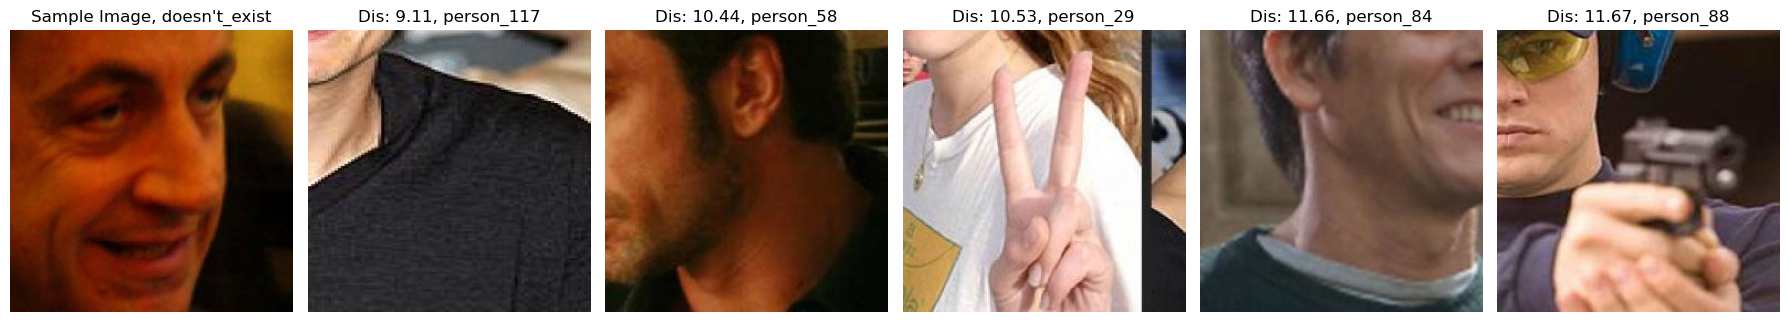

In [28]:
r = plot_sample_top_results(val_df.iloc[0])

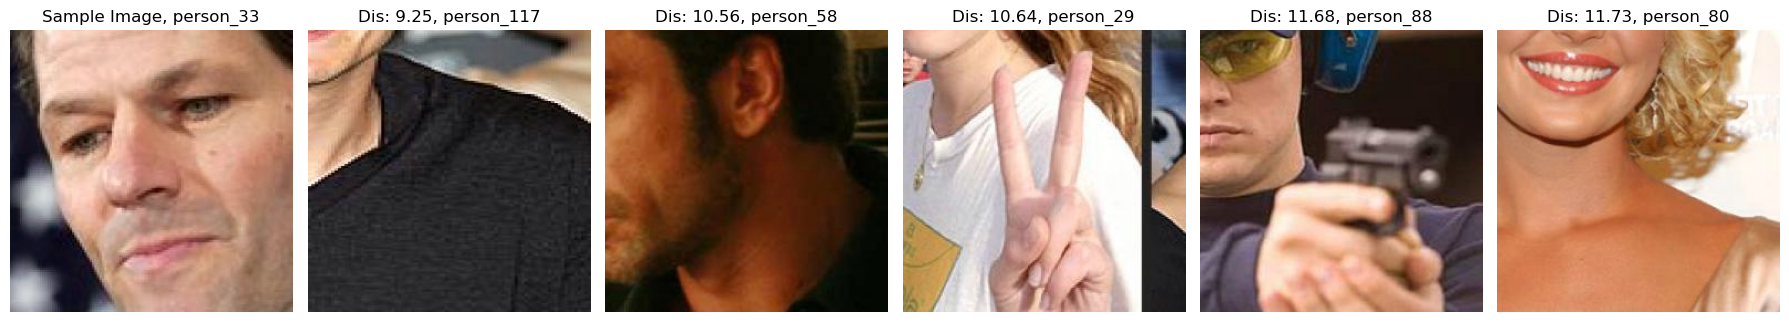

In [32]:
r = plot_sample_top_results(val_df.iloc[205])

In [31]:
r.sort_values('distance')

,embeddings,person,img,distance
1292,"[0.3751357, -0.38493237, -0.37875578, 0.475317...",person_117,1867.jpg,9.245714
4098,"[-0.005505629, -0.10767175, -0.60455096, 0.127...",person_58,5839.jpg,10.562167
2548,"[-0.36623353, -0.43766904, -0.34849462, 1.0998...",person_29,3638.jpg,10.644048
5873,"[0.69048613, -0.11256771, -0.4627085, 0.920893...",person_88,8358.jpg,11.677527
5408,"[0.8035914, -0.48277944, -0.27707225, 0.031376...",person_80,7700.jpg,11.730645
...,...,...,...,...
4788,"[0.07321738, 1.4413785, 0.04324488, -0.7845696...",person_7,6818.jpg,27.694967
2672,"[0.98419774, -1.5587156, 1.7077625, -0.4915005...",person_30,3816.jpg,27.778002
3552,"[0.61852306, -0.42182615, -0.89914715, 0.63700...",person_46,5066.jpg,27.879017
4993,"[1.4568083, 1.3397901, 2.4862022, 0.77843696, ...",person_73,7106.jpg,27.900969


In [162]:
# [ 43, 121,  89, 113,  72]